In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

CS 591 Algorithms in Society, Spring 2020
Homework 3, Section 2
Gavin Brown

My code for the empirical CDF problems.

In [2]:
def create_data(n):
    x = np.random.normal(loc=0.7, scale=0.01, size=n)
    x[x>0.99] = 0.99
    x[x<0] = 0
    return np.sort(x)

def true_cdf(x):
    y, edges = np.histogram(x, bins=2**16, range=(0,1))
    y = y/len(x) 
    y_sum = np.cumsum(y)
    
    values = np.sort(np.concatenate((x, edges[1:])))
    return values, np.interp(values, edges[1:], y_sum)

def simple_cdf(alpha, epsilon, x, values, bins_only=False):
    """return cdf on values in x, multiples of alpha"""
    # first compute true histogram
    y, edges = np.histogram(x, bins=int(1/alpha), range=(0,1))
    
    y = y/len(x) + np.random.laplace(loc=0, scale=2/(epsilon*len(x)), size=y.shape)
    
    if bins_only:
        return y
    
    y_sum = np.cumsum(y)
    
    # now do interpolation
    return np.interp(values, edges[1:], y_sum)

def tree_histogram(x, ell, epsilon, values):
    """more sophisticated algorithm"""
    ys = []
    for k in range(1, ell+1):
        alpha = 2**(-k)
        ys.append(simple_cdf(alpha, epsilon/ell, x, values, bins_only=True))
        
    # in-order traversal
    results = np.zeros(2**ell)  # stores the CDF estimate
    i = 0
    stack = []
    node = (0,0)
    while stack or node is not None:
        if node is not None:
            stack.append(node)
            if node[0] == ell-1:
                node = None
            else:
                node = (node[0]+1, 2*node[1])
        else:
            node = stack.pop()
            if node[0] == ell-1:
                results[i] += ys[node[0]][node[1]]
            else:
                start = i
                end = i+(2**(ell-node[0]-1))
                results[i:i+(2**(ell-node[0]-1))] += ys[node[0]][node[1]]
            i += 1
            if node[0] == ell-1:
                node = None
            else:
                node = (node[0]+1, 2*(node[1]+1))

    results[-1] = 1
    
    return np.interp(values, np.linspace(2**(-ell), 1, 2**(ell)), results)
            

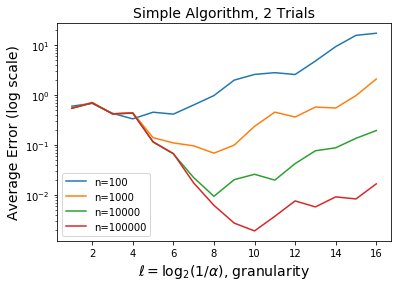

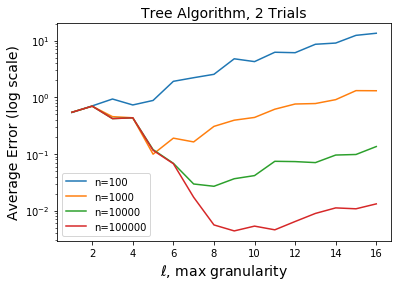

In [3]:
# test both together, two runs, all parameter settings, and plot errors

epsilon = 0.5
ns = [10**k for k in range(2,6)]
ells = range(1,17)
trials = 2

simple_errors = np.zeros((trials, len(ns), len(ells)))
tree_errors = np.zeros((trials, len(ns), len(ells)))

np.random.seed(591)
for trial in range(trials): 
    for i, n in enumerate(ns):
        x = create_data(n)
        values, truth = true_cdf(x)
        
        for j, ell in enumerate(ells):
            alpha = 2**(-ell)
            
            simple = simple_cdf(alpha, epsilon, x, values)
            error = np.max(np.abs(simple-truth))
            simple_errors[trial, i, j] = error

            tree = tree_histogram(x, ell, epsilon, values)
            error = np.max(np.abs(tree-truth))
            tree_errors[trial, i, j] = error

for i, n in enumerate(ns):
    plt.plot(ells, np.average(simple_errors[:,i,:], axis=0), label='n='+str(n))
plt.yscale('log')
plt.legend(loc='lower left')
plt.xlabel(r'$\ell=\log_2 (1/\alpha)$, granularity', fontsize=14)
plt.ylabel('Average Error (log scale)', fontsize=14)
plt.title('Simple Algorithm, '+str(trials)+' Trials', fontsize=14)
plt.show()

for i, n in enumerate(ns):
    plt.plot(ells, np.average(tree_errors[:,i,:], axis=0), label='n='+str(n))
plt.yscale('log')
plt.legend(loc='lower left')
plt.xlabel(r'$\ell$, max granularity', fontsize=14)
plt.ylabel('Average Error (log scale)', fontsize=14)
plt.title('Tree Algorithm, '+str(trials)+' Trials', fontsize=14)
plt.show()

simple error: 0.05753411304949896
tree error:   0.05988302480223523


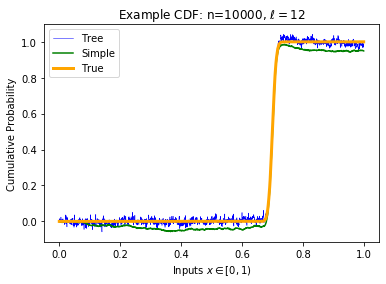

In [8]:
# test one particular parameter setting, visualize the CDF

epsilon = 0.5
n = 10000
ell = 12

np.random.seed(537)
x = create_data(n)
values, truth = true_cdf(x)

alpha = 2**(-ell)

simple = simple_cdf(alpha, epsilon, x, values)
error = np.max(np.abs(simple-truth))
print('simple error:', error)

tree = tree_histogram(x, ell, epsilon, values)
error = np.max(np.abs(tree-truth))
print('tree error:  ', error)

plt.plot(values, tree, color='blue', label='Tree', linewidth=0.5)
plt.plot(values, simple, color='green', label='Simple')
plt.plot(values, truth, color='orange' ,label='True', linewidth=3)
plt.xlabel(r'Inputs $x\in [0,1)$')
plt.ylabel(r'Cumulative Probability')
plt.title(r'Example CDF: n='+str(n)+', $\ell=$'+str(ell))
plt.legend(loc='upper left')
plt.show()